# **Covid-19 Classification Project Summary**

**Goal:**  
Build a robust deep learning model for COVID-19 diagnosis from chest X-ray images by leveraging the unique features of the COVID-QU-Ex dataset, which includes ground-truth lung and infection segmentation masks.

**Approach:**  
- The project follows a two-stage training strategy:  
  1. **Infection Segmentation:** Train a U-Net segmentation model to accurately identify infection regions in COVID-19 chest X-rays. This step helps the encoder learn detailed infection-related features.  
  2. **Classification with Transfer Learning:** Use the pretrained encoder from the segmentation stage, freeze it initially, and train a classification head to distinguish COVID-19, non-COVID infections, and normal cases using the full dataset.

- Data preprocessing involves masking non-lung pixels with noise and enhancing generalization through data augmentation and custom dataset splits to balance classes and sources.

**Key Results:**  
- The segmentation model successfully learned to localize infection areas with strong validation performance.  
- The classification model achieved robust generalization across diverse data sources and conditions, with overall F1 scores around 0.88 and accuracy near 86%.  
- Careful training design—transfer learning, lung masking, dropout, and balanced splits—helped prevent shortcut learning and dataset bias.

This approach demonstrates that leveraging segmentation pretraining and tailored data preparation leads to more accurate and generalizable COVID-19 diagnostic models from chest X-rays.


In [1]:
! pip install segmentation-models-pytorch albumentations
import os
import random
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch.nn.functional as F


import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.metrics import MeanIoU

from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

from google.colab import drive, runtime


from matplotlib.patches import Rectangle


import kagglehub
from tqdm import tqdm
from PIL import Image

import os
import cv2
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt


import numpy as np
from sklearn.metrics import f1_score,accuracy_score
from collections import defaultdict

# Mount Google Drive
drive.mount('/content/drive')

import sys

sys.path.insert(0,'/content/drive/MyDrive/Covid-19_Presence/scripts')
import covid_utils
from covid_utils import (
    train_epoch,
    val_epoch,
    create_metadata_df,
    plot_image_and_mask,
    calculate_stats_from_df,
    plot_masked_images_and_masks,
    combined_loss,
    calculate_iou,
    train_epoch_segmentation,
    validate_epoch_segmentation,
    visualize_val_predictions,
    calculate_iou_np,
    validate_lung_cropping,
    validate_with_transforms,
    validate_with_transforms_detailed,
    quick_lung_mask_check,
    check_dataloader_with_sources,
    patient_split,
    print_source_balance,
    visualize_inference_on_test_set,
    show_predictions_and_masks,
    load_best_classifier,
    evaluation_with_source,
    simple_gradcam_analysis,
    analyze_sample_simple,
    integrated_gradients_analysis,
    visualize_random_val_prediction
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.8 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# Define directories
drive_dir = '/content/drive/MyDrive'
project_dir = os.path.join(drive_dir, 'Covid-19_Presence')
models_dir = os.path.join(project_dir, 'models')

# **Modeling Plan**

The goal of this project is to build a robust deep learning model for COVID-19 diagnosis from chest X-ray images. To achieve this, the project leverages the rich features of the **COVID-QU-Ex dataset**, which provides **ground-truth lung and infection segmentation masks**.

---

### Stage 1: Infection Segmentation 🧠

Instead of directly training a CNN for classification, the first stage focuses on **semantic segmentation** to locate infection regions within the lungs. This approach has several advantages:

- Training the model to explicitly identify infection regions forces the encoder to learn detailed, pixel-level features related to COVID-19 pathology.

- This reduces the risk of the model relying on random artifacts or shortcuts (such as textual annotations or machine-specific patterns) that a direct classification model might exploit.

- Semantic segmentation encourages spatially meaningful feature extraction, capturing the shape, texture, and morphology of infection areas.

* **Model Architecture**: A U-Net or similar encoder-decoder is used, with the encoder learning rich spatial features and the decoder reconstructing infection masks.
* **Data**: The COVID-QU-Ex Infection Segmentation subset with 2,913 annotated COVID-19 CXRs.

---

### Stage 2: Classification with Transfer Learning 🚀

The pretrained encoder from the segmentation model is transferred and frozen. A new classification head, typically consisting of fully connected layers, is trained on top.

* **Objective**: Build a classifier to differentiate COVID-19, Non-COVID infections, and Normal cases.
* **Data**: The classification head is trained using a combined dataset comprising the **COVIDx CXR-2 dataset** and the **COVID-19 Radiography Dataset**, providing broad and diverse examples for better generalization.

---

This two-stage transfer learning strategy leverages the fine-grained infection feature learning from segmentation to guide classification, yielding higher accuracy and more robust generalization than training a classifier from scratch.




In [2]:
# COVID-QU-Ex dataset
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

print("Path to dataset files:", path)

100%|██████████| 1.15G/1.15G [00:07<00:00, 160MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7


In [3]:
all_data_path=os.path.join(path,'Infection Segmentation Data','Infection Segmentation Data')
train_path=os.path.join(all_data_path,'Train')
test_path=os.path.join(all_data_path,'Test')
val_path=os.path.join(all_data_path,'Val')


# Shuffle the dataframes before creating datasets
train_df = create_metadata_df(train_path).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = create_metadata_df(val_path).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = create_metadata_df(test_path).sample(frac=1, random_state=42).reset_index(drop=True)

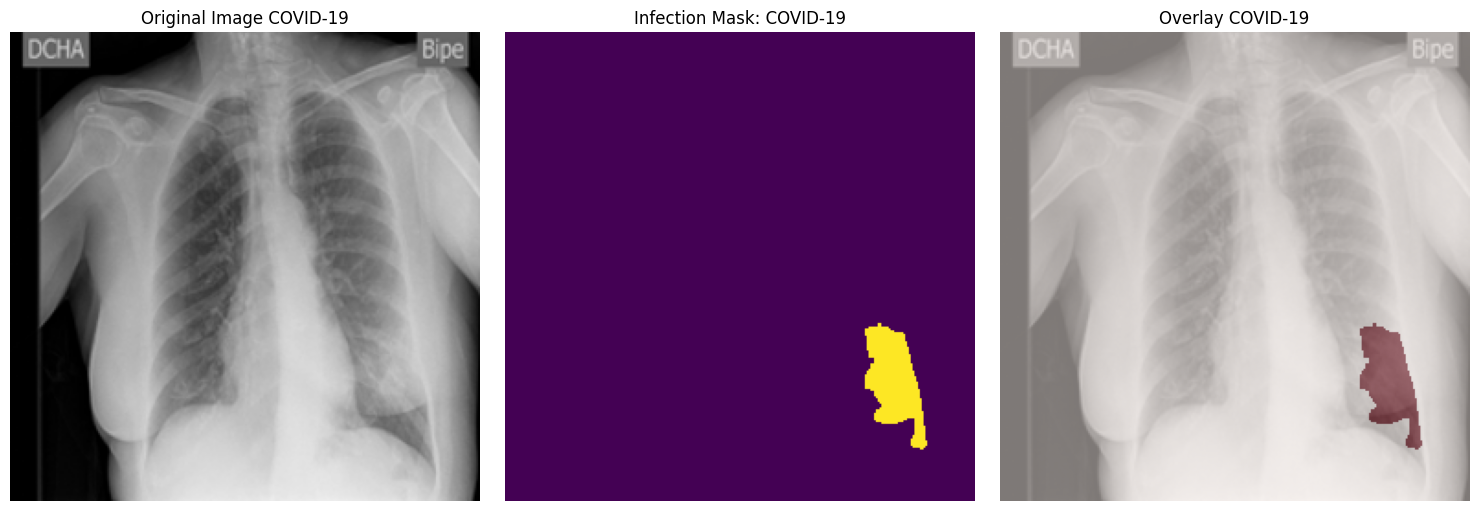

In [8]:
# Select a random row from your DataFrame
sample_df=train_df
sample_df=train_df[train_df['label'].str.contains('19')]
random_row = sample_df.sample(n=1).iloc[0]
label=random_row['label']
# Get the file paths from the DataFrame
filename = random_row['filename']
mask_path=os.path.join(random_row['infection_mask_dir'],filename)
image_path=os.path.join(random_row['image_directory'],filename)

# Call the function
plot_image_and_mask(image_path, mask_path,title=label,save_dir=os.path.join(project_dir,'ground_truth_infection_masks'))



# **Class Specific Dataframes**

In [9]:
train_df_covid=train_df[train_df['label'].str.contains('19')]
train_df_covid['label'].value_counts()
val_df_covid=val_df[val_df['label'].str.contains('19')]
val_df_covid['label'].value_counts()
test_df_covid=test_df[test_df['label'].str.contains('19')]
test_df_covid['label'].value_counts()
val_df_covid=pd.concat([val_df_covid,test_df_covid])


### 📊 **Dataset Statistics Calculation**

This step is crucial for **data normalization**, a standard practice in image processing for deep learning. We calculate the mean and standard deviation of all pixel values across our training dataset.

-   **Why it's necessary**: Normalization scales the pixel values to a standard range, typically around a mean of 0 and a standard deviation of 1. This helps to stabilize and speed up the training of our neural network. Without it, pixels with larger values could disproportionately influence the model's weights, leading to instability.

-   **Application**: The calculated `mean` and `std` values will be used in our Albumentations `Normalize` transform.
-   **Future Use Case**: These statistics are also useful for creating a realistic **noise background** or for data augmentation techniques, which can further improve model generalization.

The `calculate_stats_from_df` function processes the entire training dataframe to get these values, which only needs to be done once.

In [ ]:
# --- STEP 1: Calculate the mean and std of your dataset ---
calculated_mean, calculated_std = calculate_stats_from_df(train_df)

Calculating Stats: 100%|██████████| 3728/3728 [01:12<00:00, 51.21it/s]



✅ Calculation complete.
Raw Mean (0-255 range): 135.1460
Raw Std (0-255 range): 62.3933
Normalized Mean (0-1 range): 0.5300
Normalized Std (0-1 range): 0.2447


### 📦 **Preparing Data for U-Net Infection Segmentation**

This code defines the complete data pipeline for training a U-Net segmentation model. The process involves several key steps to prepare the input images and their corresponding target masks.

***

### Data Pipeline Overview

1.  **Image and Mask Loading**: The `InfectionSegmentationDataset` class loads the original chest X-ray images, along with their corresponding **infection masks** and **lung masks**.

2.  **Creating the Masked Input Image**: A crucial preprocessing step is the creation of a special input image. The original X-ray image is normalized and then combined with a synthesized **noise background**. This noise is generated using a normal distribution with the `NORMALIZED_MEAN` and `NORMALIZED_STD` of the dataset. The **lung mask** is used as a filter:
    * Pixels **inside** the lung regions (where the mask is positive) retain their original, normalized values.
    * Pixels **outside** the lung regions are replaced with the generated noise.

    This "masked image" serves as the model's input, forcing the U-Net to focus its learning on the information within the lung area while treating the irrelevant background as random noise. The **infection mask** is the model's target output.

3.  **Data Augmentation**: To improve the model's ability to generalize and prevent overfitting, a series of data augmentation techniques are applied to the training set using the `Albumentations` library.
    * `HorizontalFlip`: Randomly flips the image and mask horizontally.
    * `Rotate`: Rotates the image and mask by a small, random angle.
    * `RandomBrightnessContrast`: Adjusts the brightness and contrast.
    * `GaussianBlur`: Applies a Gaussian blur to simulate different imaging conditions.
    * `ToTensorV2`: Converts the processed images and masks into PyTorch tensors.

4.  **Normalization**: Both training and validation transforms include a `Normalize` step, which scales the pixel values of the input images using the pre-calculated `NORMALIZED_MEAN` and `NORMALIZED_STD`. This ensures the data is in a suitable range for model training.

***

This comprehensive data pipeline ensures that the U-Net model receives high-quality, pre-processed, and augmented data, which is essential for training an accurate and robust segmentation model.

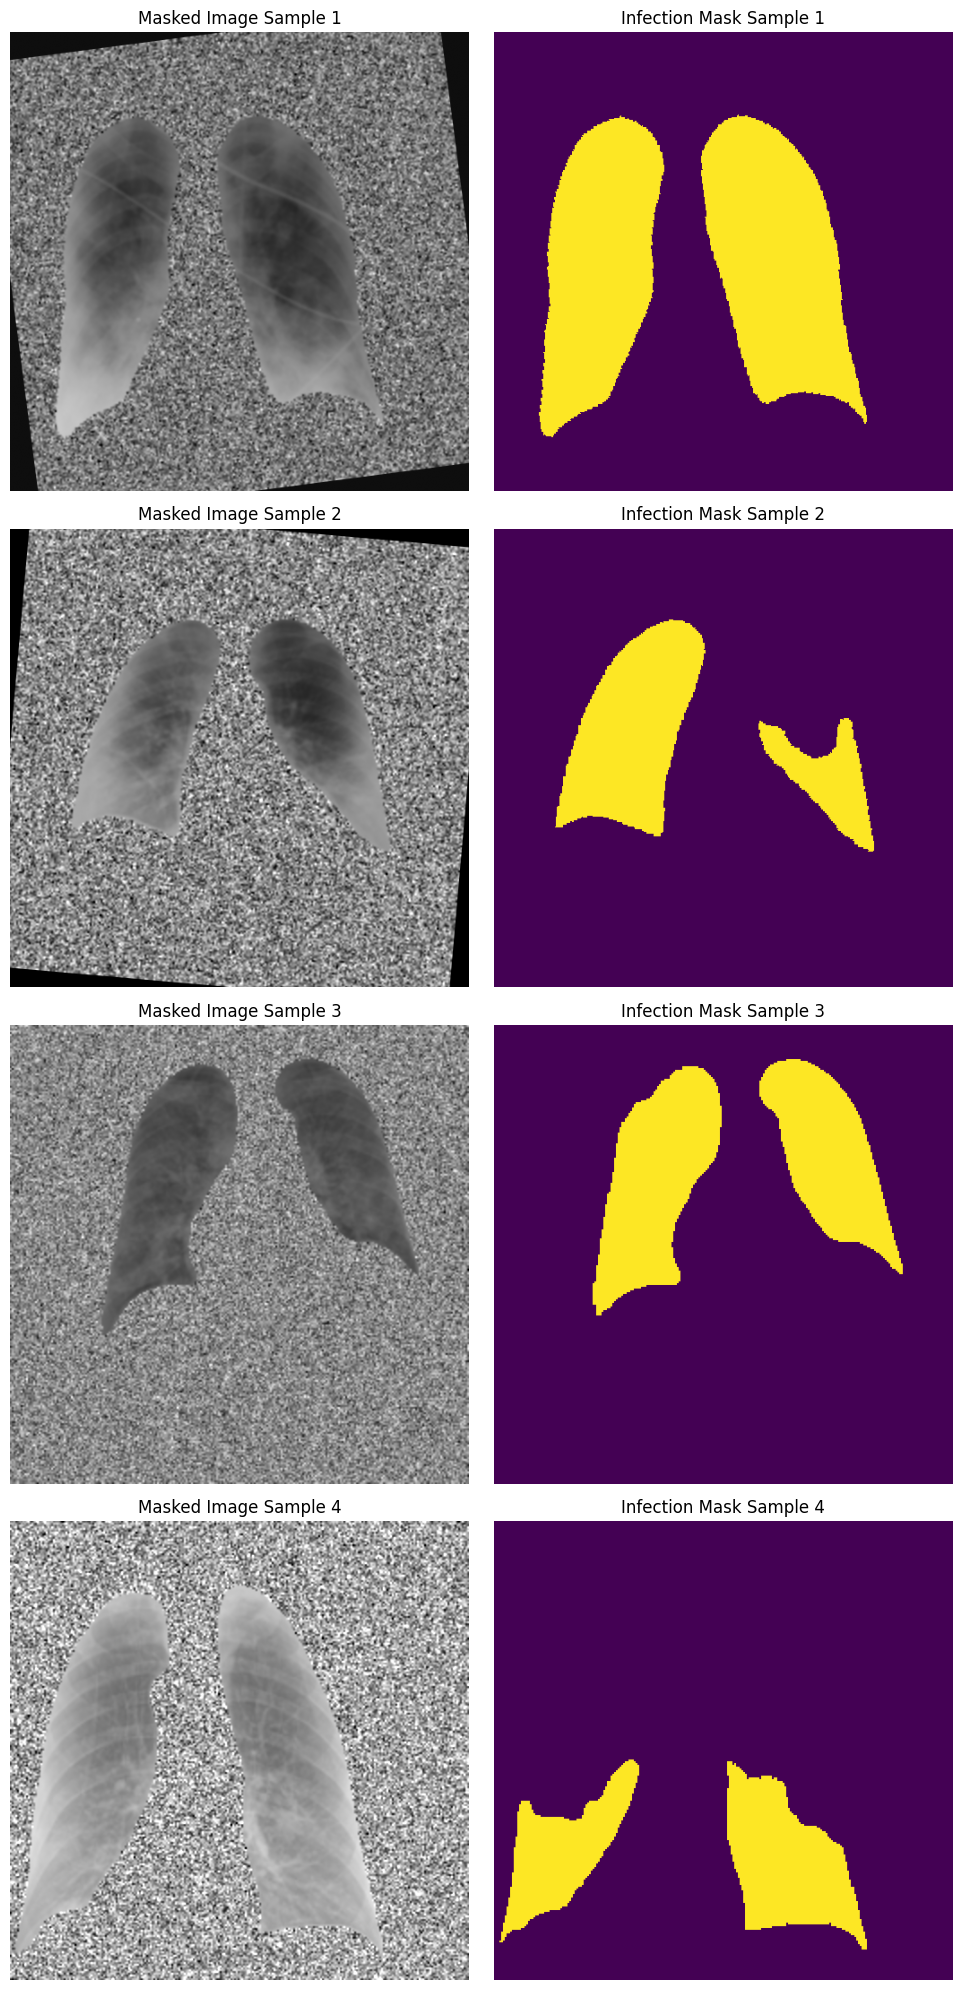

In [10]:
# Constants for normalization
NORMALIZED_MEAN = 0.5300
NORMALIZED_STD = 0.2447

class InfectionSegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Use existing DataFrame columns and file path concatenation
        img_path = os.path.join(row['image_directory'], row['filename'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Load the infection mask
        infection_mask_path = os.path.join(row['infection_mask_dir'], row['filename'])
        infection_mask = cv2.imread(infection_mask_path, cv2.IMREAD_GRAYSCALE)

        # Load the lung mask
        lung_mask_path = os.path.join(row['lung_mask_dir'], row['filename'])
        lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)

        # --- Create the noisy background image ---

        # Normalize the original image to [0, 1] range
        image_normalized = image / 255.0

        # Create a noise background with the same shape as the image
        noise = np.random.normal(loc=NORMALIZED_MEAN, scale=NORMALIZED_STD, size=image.shape).astype(np.float32)

        # Use the lung mask to combine the original image and the noise
        # Where the lung mask is True, keep the original image pixel.
        # Where the lung mask is False, use the noise pixel.
        # We use a threshold of > 0 to handle binary masks
        lung_mask_bool = lung_mask > 0
        masked_image = np.where(lung_mask_bool, image_normalized, noise)

        # The image is now in the range [0, 1]

        # --- Apply the transforms ---
        # Note: We apply the transform to the new masked_image and the infection_mask
        if self.transform:
            augmented = self.transform(image=masked_image, mask=infection_mask)
            image_final = augmented['image']
            mask_final = augmented['mask']
        else:
            image_final = masked_image
            mask_final = infection_mask

        # ToTensorV2() will handle the final conversion
        # The Normalize transform will also be applied later in the pipeline

        return image_final,  ( mask_final/ 255.0).unsqueeze(0).float()
  # --- STEP 2: Define the transforms with the calculated values ---
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.Normalize(mean=[0.5300], std=[0.2447]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.5300], std=[0.2447 ]),
    ToTensorV2(),
])

# --- STEP 3: Create the final datasets and dataloaders ---
train_dataset = InfectionSegmentationDataset(train_df_covid, train_transform)
val_dataset = InfectionSegmentationDataset(val_df_covid, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
plot_masked_images_and_masks(train_dataset, num_to_plot=4)

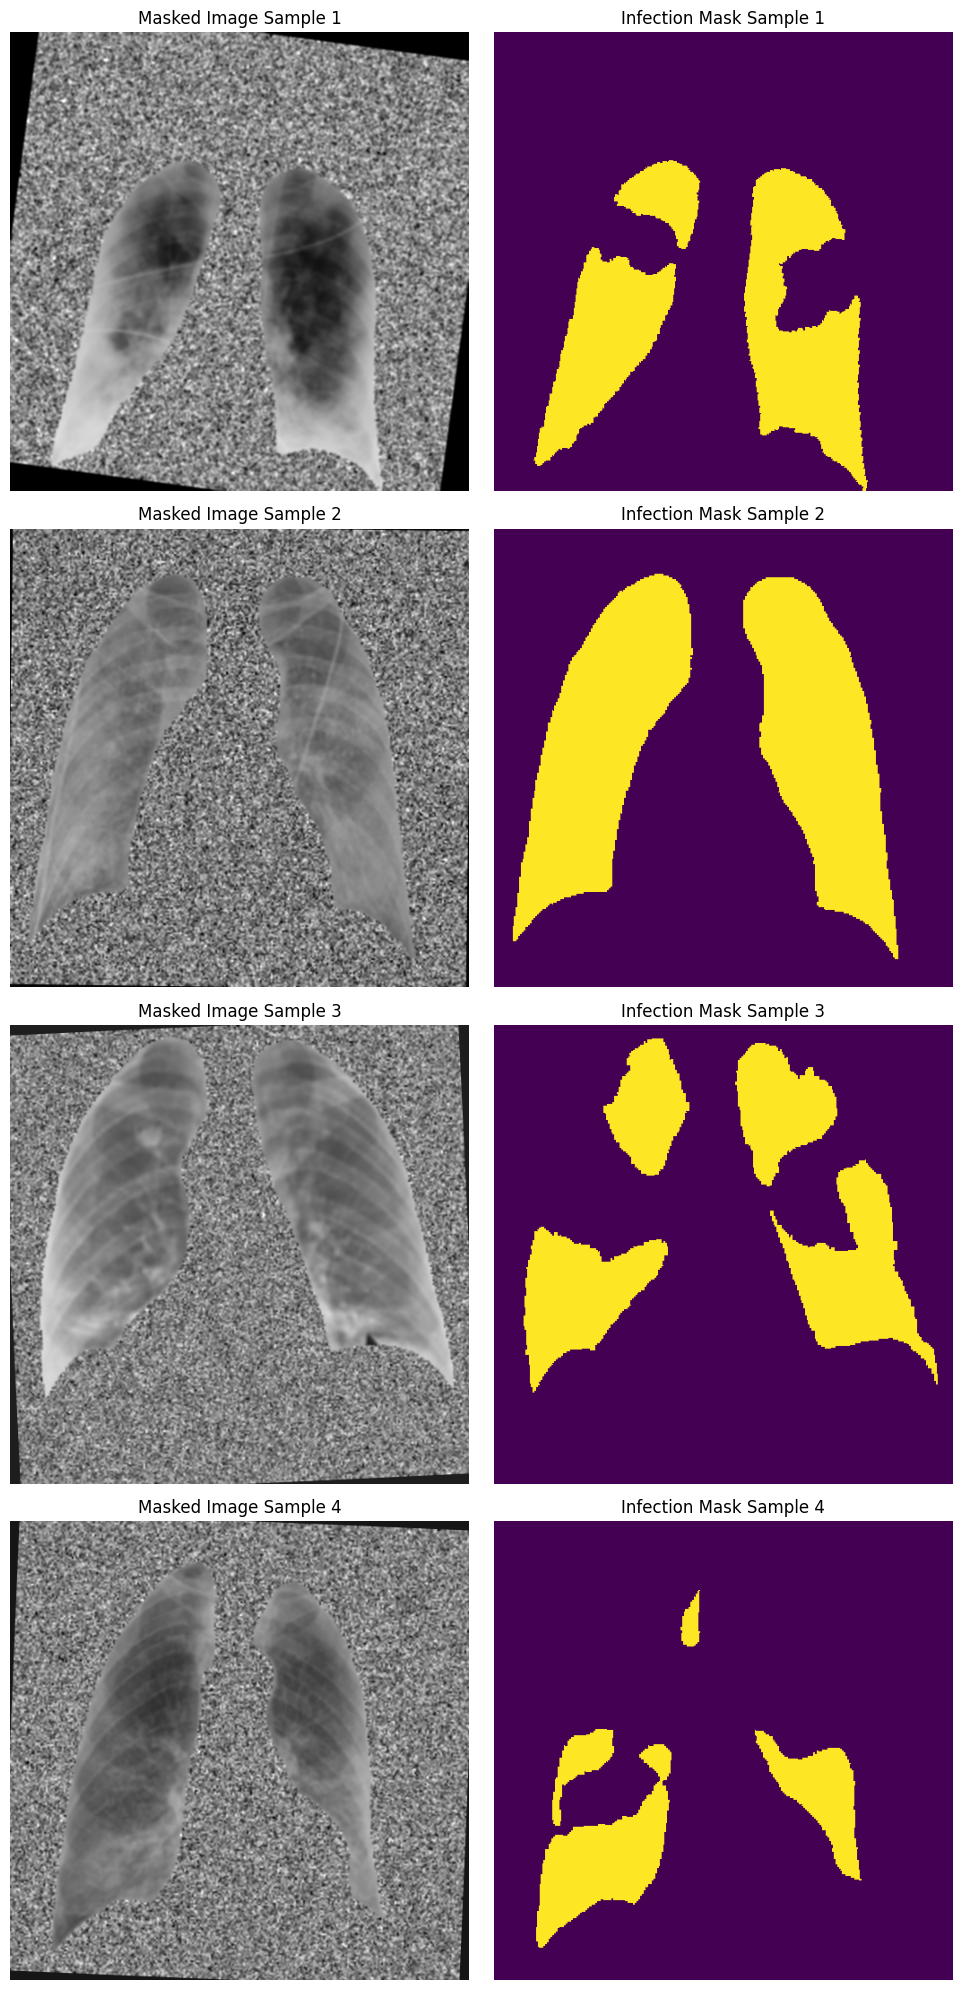

### ⚙️ **Model Setup and Training**

The next two cells set up and train the **U-Net segmentation model**. The model uses a powerful `efficientnet-b4` encoder, pre-trained on `imagenet` weights, as its backbone.

-   **Model Architecture**: A U-Net with an `efficientnet-b4` encoder is chosen for its balance of high performance and computational efficiency. The model is configured to take a single-channel (grayscale) image and output a single-channel segmentation mask.
-   **Loss Function**: A **combined loss function** is used to provide robust supervision. It combines the **Dice Loss** to handle class imbalance (the background is much larger than the infection area) with the **Binary Cross-Entropy (BCE) Loss**, which is a standard choice for binary classification tasks on a per-pixel basis.
-   **Optimizer and Scheduler**: The **AdamW optimizer** is used to update the model's weights. A **learning rate scheduler** is implemented to dynamically reduce the learning rate if the validation IoU plateaus, which helps the model converge more effectively.
-   **Training Loop**: The model is trained for a fixed number of epochs, with the best model (based on validation IoU) being saved to disk. After training, the best-performing model is loaded for evaluation.

In [11]:
# --- STEP 4: Model setup and training loop ---
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Using a combined loss function for better performance on imbalanced data

# Correct way to combine the two loss functions
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)
bce_loss = nn.BCELoss()


# Assign the combined loss to your criterion
criterion = combined_loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Starting training...

Epoch 1/50
Batch 0/233, Loss: 1.4307
Batch 20/233, Loss: 1.2116
Batch 40/233, Loss: 1.1614
Batch 60/233, Loss: 0.9872
Batch 80/233, Loss: 0.9161
Batch 100/233, Loss: 0.8459
Batch 120/233, Loss: 0.8623
Batch 140/233, Loss: 0.7289
Batch 160/233, Loss: 0.6849
Batch 180/233, Loss: 0.6204
Batch 200/233, Loss: 0.4844
Batch 220/233, Loss: 0.5756
New best model saved with IoU: 0.0000
Train Loss: 0.8669, Train IoU: 0.5793
Val Loss: 1.2912, Val IoU: 0.0000

Epoch 2/50
Batch 0/233, Loss: 0.6160
Batch 20/233, Loss: 0.4561
Batch 40/233, Loss: 0.5403
Batch 60/233, Loss: 0.3347
Batch 80/233, Loss: 0.5409
Batch 100/233, Loss: 0.3336
Batch 120/233, Loss: 0.3576
Batch 140/233, Loss: 0.3994
Batch 160/233, Loss: 0.3502
Batch 180/233, Loss: 0.4001
Batch 200/233, Loss: 0.4885
Batch 220/233, Loss: 0.5205
New best model saved with IoU: 0.2387
Train Loss: 0.4541, Train IoU: 0.6987
Val Loss: 0.8681, Val IoU: 0.2387

Epoch 3/50
Batch 0/233, Loss: 0.3933
Batch 20/233, Loss: 0.4820
Batch 40/2

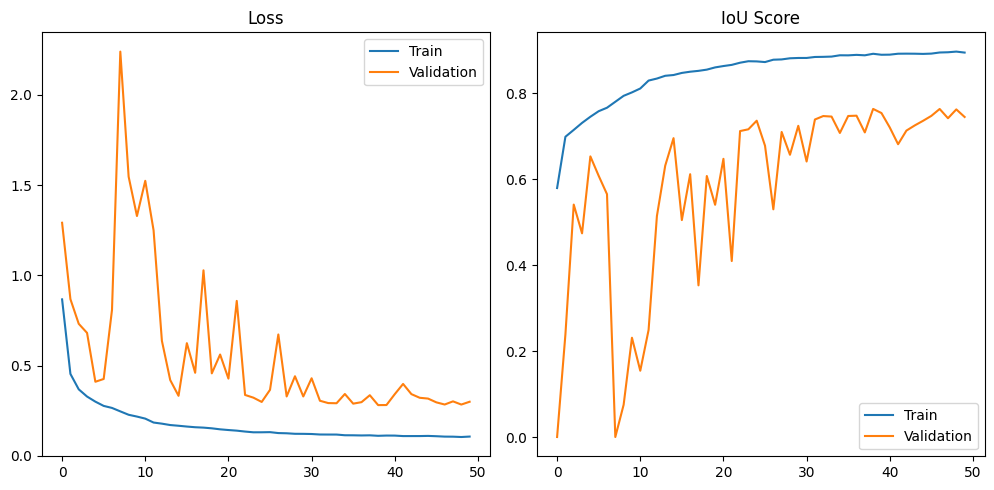

Model ready for inference!


In [16]:
def combined_loss(y_pred, y_true):
    return dice_loss(y_pred, y_true) + bce_loss(y_pred, y_true)
# --- Training loop (same as your code) ---
# Training function
def train_epoch_segmentation(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_iou = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += calculate_iou(outputs, masks)

        if batch_idx % 20 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    return total_loss / len(train_loader), total_iou / len(train_loader)

def validate_epoch_segmentation(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            if images is None: continue # Skip None batches
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks)
    return total_loss / len(val_loader), total_iou / len(val_loader)
num_epochs = 50
best_iou = 0
train_losses, val_losses = [], []
train_ious, val_ious = [], []
# PREVIOUSLY os.path.join(models_dir,'best_infection_segmentation_model.pth')
MODEL_SAVE_PATH=os.path.join(models_dir,'best_infection_segmentation_model_COVID_ONLY.pth')
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_iou = train_epoch_segmentation(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate_epoch_segmentation(model, val_loader, criterion, device)
    scheduler.step(val_iou)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'best_iou': best_iou,
        }, MODEL_SAVE_PATH)
        print(f"New best model saved with IoU: {best_iou:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

print(f"\nTraining completed! Best IoU: {best_iou:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train')
plt.plot(val_ious, label='Validation')
plt.title('IoU Score')
plt.legend()
plt.tight_layout()
plt.show()

# Load best model for inference
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model ready for inference!")


# **Visualize Predicted Infection Masks for Covid-19 Patients**

In [32]:
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)
MODEL_SAVE_PATH=os.path.join(models_dir,'best_infection_segmentation_model_COVID_ONLY.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Load best model for inference
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

# --- Example Usage ---
visualize_val_predictions(model, val_loader, device, num_samples=20)

Output hidden; open in https://colab.research.google.com to view.

# **Visualize Predicted Infection Masks For Non-Covid Infections**

In [33]:
# Assuming val_df is your main validation DataFrame
non_covid_df = val_df[val_df['label'].str.contains('Non', case=False, na=False)]
# Create a dataset using the filtered DataFrame
non_covid_dataset = InfectionSegmentationDataset(non_covid_df, transform=val_transform)

# Create a DataLoader for the normal dataset
non_covid_loader = DataLoader(non_covid_dataset, batch_size=4, shuffle=False)

# Visualize predictions on the normal images
visualize_val_predictions(model, non_covid_loader, device, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.

# **Visualize Predicted Infection Mask for Normal X-rays**

In [29]:
# Assuming val_df is your main validation DataFrame
normal_df = val_df[val_df['label'].str.contains('Normal', case=False, na=False)]
# Create a dataset using the filtered DataFrame
normal_dataset = InfectionSegmentationDataset(normal_df, transform=val_transform)

# Create a DataLoader for the normal dataset
normal_loader = DataLoader(normal_dataset, batch_size=4, shuffle=False)

# Visualize predictions on the normal images
visualize_val_predictions(model, normal_loader, device, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.



---

### **Phase 2: Training on Full Dataset**

1.  **Model Initialization**: The model is first initialized with the pre-trained weights from `imagenet` and then immediately loaded with the weights from **Phase 1**, which was trained exclusively on COVID-19 images. This is a form of **incremental learning**, where the model's knowledge of infection patterns is carried forward.

2.  **Expanded Dataset**: The core change here is that the training and validation DataFrames (`train_df` and `val_df`) now include images of normal, non-infected lungs. The `InfectionSegmentationDataset` class is robust enough to handle these cases, where the infection mask will be an all-zero tensor.

3.  **Training Objective**: The goal of this phase is to teach the model two key things:
    * **Refined Segmentation**: To improve its ability to precisely segment infections, using the broader range of COVID-19 cases in the full dataset.
    * **Robust Generalization**: To learn to produce an **all-zero mask** when presented with a normal X-ray. This is critical for preventing the model from generating false positives in healthy lungs.

4.  **Training Process**: The training loop remains the same, saving the best model based on validation IoU. The model's performance on a broader range of data will be a better indicator of its true generalization capability.

This two-phase training strategy is an effective way to first focus the model on a complex, specific task (infection segmentation on positive cases) and then fine-tune it on a more general, realistic dataset.

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)
PHASE_1_PATH=os.path.join(models_dir,'best_infection_segmentation_model_COVID_ONLY.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Load best model for inference
checkpoint = torch.load(PHASE_1_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# --- STEP 3: Create the final datasets and dataloaders ---
train_dataset = InfectionSegmentationDataset(train_df, train_transform)
val_dataset = InfectionSegmentationDataset(val_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
# --- Training loop (same as your code) ---
num_epochs = 50
best_iou = 0
train_losses, val_losses = [], []
train_ious, val_ious = [], []
# PREVIOUSLY os.path.join(models_dir,'best_infection_segmentation_model.pth')
MODEL_SAVE_PATH=os.path.join(models_dir,'best_infection_segmentation_model_COVID_ONLY_phase2.pth')
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_iou = train_epoch_segmentation(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate_epoch_segmentation(model, val_loader, criterion, device)
    scheduler.step(val_iou)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'best_iou': best_iou,
        }, MODEL_SAVE_PATH)
        print(f"New best model saved with IoU: {best_iou:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

print(f"\nTraining completed! Best IoU: {best_iou:.4f}")

Starting training...

Epoch 1/50
Batch 0/466, Loss: 0.6925
Batch 20/466, Loss: 0.4556
Batch 40/466, Loss: 0.2776
Batch 60/466, Loss: 0.4348
Batch 80/466, Loss: 0.7792
Batch 100/466, Loss: 0.1519
Batch 120/466, Loss: 0.2556
Batch 140/466, Loss: 0.6251
Batch 160/466, Loss: 0.5200
Batch 180/466, Loss: 0.5353
Batch 200/466, Loss: 0.2871
Batch 220/466, Loss: 0.3867
Batch 240/466, Loss: 0.4006
Batch 260/466, Loss: 0.9017
Batch 280/466, Loss: 0.7412
Batch 300/466, Loss: 0.1564
Batch 320/466, Loss: 0.0940
Batch 340/466, Loss: 0.3566
Batch 360/466, Loss: 0.5882
Batch 380/466, Loss: 0.4725
Batch 400/466, Loss: 0.9786
Batch 420/466, Loss: 0.4574
Batch 440/466, Loss: 0.4260
Batch 460/466, Loss: 0.8025
New best model saved with IoU: 0.4963
Train Loss: 0.5422, Train IoU: 0.5722
Val Loss: 0.6957, Val IoU: 0.4963

Epoch 2/50
Batch 0/466, Loss: 0.0992
Batch 20/466, Loss: 0.2896
Batch 40/466, Loss: 0.4000
Batch 60/466, Loss: 0.8021
Batch 80/466, Loss: 0.2947
Batch 100/466, Loss: 0.1694
Batch 120/466, Lo

KeyboardInterrupt: 

# **Attempt to train on all the Images at once**

In [25]:
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)
PHASE_1_PATH=os.path.join(models_dir,'best_infection_segmentation_model_COVID_ONLY.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# --- STEP 3: Create the final datasets and dataloaders ---
train_dataset = InfectionSegmentationDataset(train_df, train_transform)
val_dataset = InfectionSegmentationDataset(val_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
# --- Training loop (same as your code) ---
num_epochs = 50
best_iou = 0
train_losses, val_losses = [], []
train_ious, val_ious = [], []
# PREVIOUSLY os.path.join(models_dir,'best_infection_segmentation_model.pth')
MODEL_SAVE_PATH=os.path.join(models_dir,'best_infection_segmentation_model_all_data_.pth')
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_iou = train_epoch_segmentation(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate_epoch_segmentation(model, val_loader, criterion, device)
    scheduler.step(val_iou)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'best_iou': best_iou,
        }, MODEL_SAVE_PATH)
        print(f"New best model saved with IoU: {best_iou:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

print(f"\nTraining completed! Best IoU: {best_iou:.4f}")

Starting training...

Epoch 1/50
Batch 0/233, Loss: 1.5213
Batch 20/233, Loss: 1.5052
Batch 40/233, Loss: 1.4596
Batch 60/233, Loss: 1.4758
Batch 80/233, Loss: 1.4801
Batch 100/233, Loss: 1.4762
Batch 120/233, Loss: 1.4845
Batch 140/233, Loss: 1.4749
Batch 160/233, Loss: 1.5075
Batch 180/233, Loss: 1.4572
Batch 200/233, Loss: 1.4867
Batch 220/233, Loss: 1.4910
New best model saved with IoU: 0.0420
Train Loss: 1.4904, Train IoU: 0.0281
Val Loss: 1.5153, Val IoU: 0.0420

Epoch 2/50
Batch 0/233, Loss: 1.4921
Batch 20/233, Loss: 1.4563
Batch 40/233, Loss: 1.4879
Batch 60/233, Loss: 1.5161
Batch 80/233, Loss: 1.4753
Batch 100/233, Loss: 1.5161
Batch 120/233, Loss: 1.5356
Batch 140/233, Loss: 1.4873
Batch 160/233, Loss: 1.4947
Batch 180/233, Loss: 1.4723
Batch 200/233, Loss: 1.5251
Batch 220/233, Loss: 1.4766
Train Loss: 1.4904, Train IoU: 0.0281
Val Loss: 1.4850, Val IoU: 0.0236

Epoch 3/50
Batch 0/233, Loss: 1.4853
Batch 20/233, Loss: 1.4861
Batch 40/233, Loss: 1.4985
Batch 60/233, Loss: 1

KeyboardInterrupt: 

## **COVID-19 Lung Infection Segmentation - Stage Summary**

1. Initial training was performed in stages: first on COVID-positive samples, then on non-COVID samples.

2. Training on the entire combined dataset at once was also attempted.

3. The best empirical results were achieved by training only on COVID-positive samples, which helped the model focus on learning COVID-specific infection features.

4. Although the model's features may not yet fully distinguish COVID-19 infection from other lung opacities, they do differentiate COVID-19 chest X-rays from normal ones. This is supported by the observation that predicted infection masks are substantially smaller or nearly absent on normal X-rays, even without training on normal data.

5. A primary challenge throughout the project has been preventing the model from learning shortcut features correlated with specific machines, sources, or dataset biases rather than genuine COVID pathology.

6. The next stage will involve fine-tuning by adding a classification head to the encoder, aiming for a robust COVID vs. non-COVID binary classifier.

This stage laid a solid foundation by enabling the model to learn meaningful infection-related features directly associated with COVID-19, while careful training design mitigated data bias shortcuts.


# **Stage 2: Classification with Transfer Learning**

The next stage of the project is to build a powerful COVID-19 classifier by leveraging the feature extraction capabilities of the pre-trained segmentation model. This is a form of transfer learning where the knowledge gained from the segmentation task is applied to a new, but related, classification task.

***

### Data Sources and Preparation

The classification model will be trained on a combined dataset from two sources to ensure robustness and a wide variety of examples:

1.  **COVID-19 Radiography Database**: This dataset contains images categorized as Normal, COVID, Viral Pneumonia, and Lung Opacity. This diverse collection of X-rays will be used to train the classification head to differentiate between various conditions.

2.  **COVIDx-CXR2**: This second dataset will be incorporated to further augment the training data, providing more examples and improving the model's ability to generalize to unseen images.

The data will be split on a per-patient basis to avoid data leakage and ensure that images from the same patient do not appear in both the training and validation sets. This ensures a more realistic evaluation of the model's performance on new patients.

***

### Model Architecture and Strategy

The classification model is built upon the same **EfficientNet-B4 encoder** used in the segmentation model. The key steps are:

1.  **Encoder Transfer**: The `efficientnet-b4` encoder, which has been pre-trained on the segmentation task, is loaded into the new classifier model. This encoder is highly effective at extracting low-level and high-level features from chest X-ray images, having learned to identify intricate patterns related to lung and infection morphology.

2.  **New Classification Head**: A new `classification_head` is added on top of the transferred encoder. This head is composed of multiple linear layers with ReLU activation and several **Dropout** layers. Dropout is a crucial regularization technique that helps prevent overfitting to the training data.

3.  **Training**: During the training phase, the weights of the `efficientnet-b4` encoder will likely be frozen initially, and only the new classification head will be trained. This allows the model to quickly learn how to map the encoder's powerful features to the final classification labels (e.g., COVID, Non-COVID, Normal). After an initial training period, the entire model can be fine-tuned with a very low learning rate.

This two-stage approach—pre-training for segmentation followed by transfer learning for classification—is a highly effective strategy for medical image analysis tasks, allowing the model to learn meaningful representations from limited data.

In [12]:
# Covid-19 Radiography Dataset Images
covid_utils.retrieve_and_process_data()
main_dir='/content/data'


base=os.path.join(main_dir,"COVID-19_Radiography_Dataset")
subfolders=['Normal','COVID','Viral Pneumonia','Lung_Opacity']
S=0
size_dict={}
for folder in subfolders:
    print(folder)
    print( f'\tSize: {len(os.listdir(os.path.join(base,folder,"masks")))}')
    size_dict[folder]=len(os.listdir(os.path.join(base,folder,"masks")))
paths = [
        (os.path.join(base, 'Lung_Opacity', 'images'), os.path.join(base, 'Lung_Opacity', 'masks')),
        (os.path.join(base, 'Normal', 'images'), os.path.join(base, 'Normal', 'masks')),
        (os.path.join(base, 'COVID', 'images'), os.path.join(base, 'COVID', 'masks')),
        (os.path.join(base, 'Viral Pneumonia', 'images'), os.path.join(base, 'Viral Pneumonia', 'masks'))
    ]

image_fnames=[]
mask_fnames=[]
dirs=[]
mask_dir=[]

for image_directory, mask_directory in paths:
    for image_filename, mask_filename in zip(sorted(os.listdir(image_directory)), sorted(os.listdir(mask_directory))):
        image_fnames.append(image_filename)
        mask_fnames.append(mask_filename)
        dirs.append(image_directory)
        mask_dir.append(mask_directory)
fnames_df=pd.DataFrame({'filename':image_fnames,'Image_Directory':dirs})
fnames_df['source']='C19RD'
fnames_df['patient_id']='unknown'
fnames_df['label']=fnames_df['filename'].apply(lambda x: 'positive' if 'COVID' in x else 'negative')
test_positive=fnames_df[fnames_df['label']=='positive']
test_negative=fnames_df[fnames_df['label']=='negative']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from COVID-19_Radiography_Dataset.zip to /content/data
Normal
	Size: 10192
COVID
	Size: 3616
Viral Pneumonia
	Size: 1345
Lung_Opacity
	Size: 6012


In [13]:
# Load data from COVIDx CXR-2
path = kagglehub.dataset_download("andyczhao/covidx-cxr2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covidx-cxr2' dataset.
Path to dataset files: /kaggle/input/covidx-cxr2


In [14]:
train_file = os.path.join(path, 'train.txt')
val_file = os.path.join(path, 'val.txt')
test_file = os.path.join(path, 'test.txt')

train_df = pd.read_csv(train_file, sep=' ', header=None, names=['patient_id', 'filename', 'label', 'source'])
train_df['Image_Directory']=os.path.join(path,'train')
val_df = pd.read_csv(val_file, sep=' ', header=None, names=['patient_id', 'filename', 'label', 'source'])
val_df['Image_Directory']=os.path.join(path,'val')
test_df = pd.read_csv(test_file, sep=' ', header=None, names=['patient_id', 'filename', 'label', 'source'])
test_df['Image_Directory']=os.path.join(path,'test')

# Pool all the data
print_source_balance(train_df,val_df,test_df)
all_covidx_data=pd.concat([train_df,val_df,test_df])

*******Training**********
Positive source value counts source
bimcv         42495
stonybrook    12696
sirm            878
ricord          834
cohen           251
actmed           23
fig1             22
Name: count, dtype: int64
Negative source value counts source
rsna      9719
bimcv      647
cohen      220
actmed      78
Name: count, dtype: int64

*******Validation**********
Positive source value counts source
bimcv         3151
stonybrook     940
sirm            65
ricord          62
cohen           19
actmed           2
fig1             2
Name: count, dtype: int64
Negative source value counts source
rsna      3869
bimcv      257
cohen       77
actmed      29
Name: count, dtype: int64

*******Testing**********
Positive source value counts source
bimcv     4041
ricord     200
Name: count, dtype: int64
Negative source value counts source
bimcv    4041
rsna      200
Name: count, dtype: int64



### **Dataset Split Analysis**

This analysis examines the pre-existing data splits for the combined COVID-19 datasets, highlighting the challenges that necessitated a custom split. The primary issue with the original splits was an insufficient number of negative samples from specific sources, particularly **BIMCV**, which would have led to an unbalanced dataset and poor model generalization.

***

### Data Distribution by Source

* **Original Training Data**: The training set is heavily skewed towards **positive samples**, with a significant majority coming from the BIMCV and Stonybrook sources. There is a clear **class imbalance**, with far fewer negative samples.
* **Original Validation Data**: Similar to the training set, the validation data also has an imbalance, with many more positive samples than negative ones.
* **Original Test Data**: The test set is more balanced, but it only includes data from a limited number of sources (**BIMCV, RICORD, and RSNA**). This split is not representative of all the available data, and it is crucial to test the model on all sources to ensure its robustness.

### Custom Splitting Strategy

Because of these imbalances and the lack of negative samples from certain sources, a custom splitting strategy was implemented.

* **Balancing Sources**: The custom split ensured that the model was trained on a more balanced mix of positive and negative samples, regardless of their original source.
* **Patient-Based Split**: To prevent data leakage, the data was split on a **per-patient basis** to ensure that a patient's images would only appear in a single set (train, validation, or test).
* **Focus on Sources with Both Classes**: In the initial training phase, the focus was on sources that contained both positive and negative samples, such as BIMCV and Cohen. Sources that were single-class, such as **RSNA** (all negative) and **Stonybrook** (all positive), were initially excluded from the training to ensure the model learned to differentiate between classes, but were later introduced to improve generalization.

This strategic approach to data splitting is essential for building a reliable and trustworthy classification model that performs well across diverse data sources.

In [15]:
# Combine data from Covid-19 Radiography Dataset and COVIDx CXR-2
print(all_covidx_data.columns)
print(fnames_df.columns)

all_covidx_data= all_covidx_data[['patient_id', 'filename', 'label', 'source', 'Image_Directory']]
fnames_df=fnames_df[['patient_id', 'filename', 'label', 'source', 'Image_Directory']]
fnames_df['patient_id']=[str(i)+'unknown' for i in range(len(fnames_df))]
all_data=pd.concat([all_covidx_data,fnames_df])

train, val, test = patient_split(all_data)

print('**'*15,'Label Distribution','**'*15)
print("Train label distribution:")
print(train['label'].value_counts())

print("\nValidation label distribution:")
print(val['label'].value_counts())



print("\nTest label distribution:")
print(test['label'].value_counts())
print()
print('**'*15,'Label Distribution By Source','**'*15)
print()
print("Label distribution for each source in training set:")
print(train.groupby('source')['label'].value_counts())

print("\nLabel distribution for each source in validation set:")
print(val.groupby('source')['label'].value_counts())

print("\nLabel distribution for each source in test set:")
print(test.groupby('source')['label'].value_counts())

Index(['patient_id', 'filename', 'label', 'source', 'Image_Directory'], dtype='object')
Index(['filename', 'Image_Directory', 'source', 'patient_id', 'label'], dtype='object')
****************************** Label Distribution ******************************
Train label distribution:
label
positive    44848
negative    23408
Name: count, dtype: int64

Validation label distribution:
label
positive    10922
negative     5893
Name: count, dtype: int64

Test label distribution:
label
positive    13527
negative     7385
Name: count, dtype: int64

****************************** Label Distribution By Source ******************************

Label distribution for each source in training set:
source      label   
C19RD       negative    11176
            positive     2309
actmed      negative       58
            positive       17
bimcv       positive    31767
            negative     3134
cohen       negative      197
            positive      175
fig1        positive       18
ricord      positiv

## **COVID-19 Classification Model Setup**

- **Encoder Backbone:**  
  The model uses the encoder part of a U-Net architecture with EfficientNet-B4 as the backbone. This encoder is pretrained on ImageNet and initially trained for lung infection segmentation, enabling it to extract rich hierarchical features from 1-channel chest X-ray inputs.

- **Classification Head:**  
  On top of the encoder’s final feature map, a multilayer perceptron (MLP) classification head is built with three fully connected layers:  
  - First layer: 512 units with ReLU activation and dropout (0.3)  
  - Second layer: 256 units with ReLU activation and dropout (0.3)  
  - Third layer: 128 units with ReLU activation and dropout (0.2)  
  - Final output layer projects to a single logit for binary COVID-19 presence classification.

- **Model Flow:**  
  The input passes through the EfficientNet-B4 encoder to produce a high-level feature tensor, which is then pooled, flattened, and passed through the MLP head to produce the final classification output.

- **Device Setup and Testing:**  
  The model is designed to run on GPU if available, with a test dummy input of shape (1, 1, 512, 512) to verify the forward pass and output dimensions.

This architecture leverages powerful pretrained feature extraction from the segmentation task combined with a dedicated classification head to predict COVID-19 presence robustly.


In [16]:
class CovidClassifier(nn.Module):
    def __init__(self, encoder_name="efficientnet-b4", num_classes=1,dropouts=[0.3,0.3,0.2]):
        super().__init__()

        self.encoder = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=1,
            classes=1,
        ).encoder

        encoder_out_channels = self.encoder.out_channels[-1]

        # Much more substantial classification head
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(encoder_out_channels, 512),
            nn.ReLU(),
            nn.Dropout(dropouts[0]),  #Original 0.3
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropouts[1]),# original 0.3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropouts[2]), # original 0.2
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        # The encoder returns a tuple of feature maps, we want the last one
        features = self.encoder(x)
        last_features = features[-1] # Get the last feature map from the list

        # Pass the final feature map through the classification head
        output = self.classification_head(last_features)

        return output



# --- Model setup ---
# Use the same encoder as segmentation model
model = CovidClassifier(encoder_name="efficientnet-b4", num_classes=1)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model successfully loaded on {device}")
print("\nModel Architecture:")
print(model)

# --- Test with a dummy input ---
dummy_input = torch.randn(1, 1, 512, 512).to(device)
output = model(dummy_input)

print("\nTesting with a dummy tensor...")
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output values: {output.squeeze().item():.4f}")

Model successfully loaded on cuda

Model Architecture:
CovidClassifier(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, k

### 🎨 **Custom Dataset for Classification**

This section outlines the setup for the custom `CovidClassifierDataset` and the corresponding data loaders. The dataset class is uniquely designed to process raw images by first generating a lung mask and then using that mask to create a clean, noise-masked input for the classification model.

---

#### Key Components of the Dataset Class

1.  **Automated Lung Segmentation**: A pre-trained UNet model, which you trained from scratch in a previous step, is used to predict the lung segmentation mask for each image.
    * **Workflow**: The `__getitem__` method loads the raw image and passes it to the pre-trained `self.lung_model` to generate a segmentation mask. This process ensures that the classification model only sees the relevant lung region.
    * **Purpose**: By using a dedicated model for lung segmentation, the classification model can focus its learning on the subtle features of infection rather than on identifying the lung boundaries, which significantly improves its efficiency and accuracy.

2.  **Noise-Masked Input**: The generated lung mask is then used to create a new input image. Pixels outside the segmented lung area are replaced with a noise background, a technique also used in your segmentation training. This forces the model to ignore irrelevant features outside the lungs, like the heart or ribs, and concentrate on the lung parenchyma itself.

3.  **Dynamic Source Balancing**: The `on_epoch_end` method implements a dynamic sampling strategy for the training set. At the end of each epoch, it re-samples the training data to balance the number of positive and negative samples **for each source**. This is crucial for sources with an inherent class imbalance, such as BIMCV, and helps prevent the model from becoming biased towards the majority class.

4.  **Custom Collate Function**: The `collate_with_source` function is a custom utility that handles the output from the `__getitem__` method. It correctly bundles the images, labels, and source information into a batch that can be efficiently processed by the `DataLoader`, ensuring that the source metadata is preserved for later analysis and evaluation.

This robust data pipeline ensures that the classification model is trained on clean, focused, and balanced data, a critical step for achieving a high-performing and generalizable model.

## **Classification Dataset Setup**

- The classification dataset setup largely mirrors the infection segmentation setup, with some key differences due to lack of provided lung masks in the classification data.

- To isolate lung regions, a pretrained U-Net lung segmentation model (reference: [jprich1984/Lung_Segmentation](https://github.com/jprich1984/Lung_Segmentation)) is used to predict lung masks for each chest X-ray.

- Lung masks are generated dynamically within the dataset's `__getitem__` method, which enables cropping and masking of the lung areas without relying on external masks.

- Pixels outside the predicted lung regions are replaced with random noise sampled from a normal distribution, using the same mean (0.5300) and standard deviation (0.2447) normalization constants found previously in the infection segmentation data.

- This noisy background masking encourages the classifier to focus learning on lung regions, improving robustness to background artifacts and irrelevant features.

- Dynamic sample balancing by source and label is performed at epoch end to prevent source bias and class imbalance during training.

This approach enables effective lung-focused training for COVID-19 classification using only raw chest X-rays and lung masks inferred from a robust pretrained segmentation model.


In [32]:
import cv2
import numpy as np
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

# Constants for normalization
NORMALIZED_MEAN = 0.5300
NORMALIZED_STD = 0.2447

class CovidClassifierDataset(Dataset):
    def __init__(self, df, transform=None, kind='val', balance_by_source=False,
                 source_list=None, shuffle_seed=42):
        """
        Flexible COVID classifier dataset

        Args:
            df: DataFrame with image data
            transform: Albumentations transforms
            kind: 'train' or 'val' - affects whether balancing is applied
            balance_by_source: If True, balance within each source. If False, balance globally by label
            source_list: List of sources to include when balancing by source. If None, uses all sources
            shuffle_seed: Random seed for initial shuffle. If None, no seed used
        """
        self.all_data = df.copy()
        self.df = self.all_data.copy()

        # Initial shuffle
        if shuffle_seed is not None:
            self.df = self.df.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)
        else:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

        self.transform = transform
        self.kind = kind
        self.balance_by_source = balance_by_source
        self.source_list = source_list

        # Load lung segmentation model once
        model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
        self.lung_model = tf.keras.models.load_model(model_path, compile=False)
        self.lung_model.trainable = False

    def __len__(self):
        return len(self.df)

    def get_lung_crop_bbox(self, img_path, original_size):
        """Get bounding box of lung region"""
        # Load and predict lung mask
        img_256 = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_arr = tf.keras.preprocessing.image.img_to_array(img_256).squeeze() / 255.0
        img_arr = np.expand_dims(img_arr, axis=0)

        mask_pred = self.lung_model.predict(img_arr, verbose=0)
        mask = (mask_pred.squeeze() > 0.5).astype(np.uint8)

        # Scale mask coordinates to original image size
        h_orig, w_orig = original_size
        mask_resized = cv2.resize(mask, (w_orig, h_orig))

        # Find bounding box of lung region
        coords = np.where(mask_resized > 0)
        if len(coords[0]) == 0:
            return None  # No lung detected

        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()

        # Add padding
        padding = 20
        y_min = max(0, y_min - padding)
        x_min = max(0, x_min - padding)
        y_max = min(h_orig, y_max + padding)
        x_max = min(w_orig, x_max + padding)

        return (y_min, y_max, x_min, x_max)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(row['Image_Directory'], row['filename'])

        # Load original image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        original_size = image.shape

        # --- Generate Lung Mask Using Your Model ---
        # Load and preprocess for the TF model
        img_256 = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_arr = tf.keras.preprocessing.image.img_to_array(img_256).squeeze() / 255.0
        img_arr = np.expand_dims(img_arr, axis=0)

        # Predict the lung mask
        mask_pred = self.lung_model.predict(img_arr, verbose=0)
        mask = (mask_pred.squeeze() > 0.5).astype(np.float32)

        # Resize the predicted mask to the original image size
        lung_mask = cv2.resize(mask, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)

        # --- Create the noisy background image ---

        # Normalize the original image to [0, 1] range for consistency
        image_normalized = image / 255.0

        # Create a noise background with the same shape as the image
        noise = np.random.normal(loc=NORMALIZED_MEAN, scale=NORMALIZED_STD, size=image.shape).astype(np.float32)

        # Use the lung mask to combine the original image and the noise
        lung_mask_bool = lung_mask > 0.5
        masked_image = np.where(lung_mask_bool, image_normalized, noise)

        # --- Apply the PyTorch-compatible transforms ---
        if self.transform:
            # Note: Albumentations expects images in the [0, 1] range and will normalize them
            augmented = self.transform(image=masked_image)
            masked_image = augmented['image']

        # --- Handle the label (already a float) ---
        label = 1.0 if row['label'] == 'positive' else 0.0
        source = row['source']  # Get the source for this sample

        # Return image, label, and source
        return masked_image, torch.tensor(label, dtype=torch.float32), source

    def balance_by_source_method(self, train):
        """Balance positive/negative within each specified source"""
        new_train = pd.DataFrame()

        # Use provided source list or get unique sources from data
        sources_to_use = self.source_list if self.source_list else train['source'].unique()

        for source in sources_to_use:
            data = train[train['source'] == source]
            if len(data) == 0:
                continue

            data_pos = data[data['label'] == 'positive']
            data_neg = data[data['label'] == 'negative']

            # Skip sources with only one class
            if len(data_pos) == 0 or len(data_neg) == 0:
                print(f"Warning: Source '{source}' has only one class, skipping balance")
                new_train = pd.concat([new_train, data])
                continue

            if len(data_pos) > len(data_neg):
                data_pos = data_pos.sample(n=len(data_neg))
            else:
                data_neg = data_neg.sample(n=len(data_pos))

            new_train = pd.concat([new_train, data_pos, data_neg])

        return new_train

    def balance_by_label_method(self, train):
        """Balance positive/negative globally across all sources"""
        data_pos = train[train['label'] == 'positive']
        data_neg = train[train['label'] == 'negative']

        if len(data_pos) == 0 or len(data_neg) == 0:
            print("Warning: Dataset has only one class, no balancing needed")
            return train

        if len(data_pos) > len(data_neg):
            data_pos = data_pos.sample(n=len(data_neg))
        else:
            data_neg = data_neg.sample(n=len(data_pos))

        new_train = pd.concat([data_pos, data_neg])
        return new_train

    def on_epoch_end(self):
        """Called at the end of each epoch to rebalance and reshuffle data"""
        if self.kind == 'train':
            if self.balance_by_source:
                self.df = self.balance_by_source_method(self.all_data)
            else:
                self.df = self.balance_by_label_method(self.all_data)

        # Always shuffle after balancing
        self.df = self.df.sample(frac=1).reset_index(drop=True)

# Custom collate function to handle the additional source information
def collate_with_source(batch):
    """
    Custom collate function to handle batches with source information

    Args:
        batch: List of tuples (image, label, source)

    Returns:
        Tuple of (images_tensor, labels_tensor, sources_list)
    """
    images, labels, sources = zip(*batch)

    # Stack images and labels into tensors
    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(labels)

    # Keep sources as a list (since they're strings)
    sources_list = list(sources)

    return images_tensor, labels_tensor, sources_list

# Use the SAME normalization values as your segmentation model
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5300], std=[0.2447]),  # Same as segmentation
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.5300], std=[0.2447]),  # Same as segmentation
    ToTensorV2(),
])

# For training with source-specific balancing:
train_dataset = CovidClassifierDataset(train, transform=train_transform, kind='train',
                                       balance_by_source=True, source_list=['bimcv', 'cohen', 'actmed', 'C19RD'])



# For validation/testing (no balancing):
val_dataset = CovidClassifierDataset(val, transform=val_transform, kind='val')

test_dataset=CovidClassifierDataset(test, transform=val_transform, kind='val')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_with_source)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

print("DataLoaders successfully created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


DataLoaders successfully created.
Number of training samples: 68256
Number of validation samples: 16815
Number of test samples: 20912


In [33]:
# Check lung segmentation quality
quick_lung_mask_check(train_dataset, idx=0)

# Compare original vs cropped
validate_lung_cropping(train_dataset, num_samples=6)

# Check final processed images
validate_with_transforms(train_dataset, num_samples=8)

# Check detailed comparison
validate_with_transforms_detailed(train_dataset, num_samples=4)

# Check dataloader functionality
check_dataloader_with_sources(train_loader, num_batches=2)

Output hidden; open in https://colab.research.google.com to view.

# **Build Model**
- Load the encoder weights from the infection segmentation model
- Encoder weights were unfrozen
- Dropout layers 0.3, 0,3, and 0.2

In [19]:
base_unfrozen=True
model_path = os.path.join(models_dir, 'best_infection_segmentation_model_COVID_ONLY.pth')

# --- 1. Load the trained segmentation model's state_dict ---
checkpoint = torch.load(model_path, map_location=device)
segmentation_state_dict = checkpoint['model_state_dict']

# --- 2. Transfer weights to the existing model from Block 1 ---
# We only want to load the encoder weights.
# The keys in the segmentation model start with 'encoder.'
encoder_weights = {
    key.replace('encoder.', ''): value for key, value in segmentation_state_dict.items() if key.startswith('encoder.')
}

# Load weights into the model's encoder (using 'model' from Block 1)
model.encoder.load_state_dict(encoder_weights)

print("Weights from the segmentation model's encoder have been successfully loaded onto the classification model.")


# Freeze the encoder weights (optional)
for param in model.encoder.parameters():
  param.requires_grad = base_unfrozen

# Check to confirm the weights are frozen/unfrozen
print("Are the encoder's parameters frozen?")
print(f"First parameter requires_grad: {list(model.encoder.parameters())[0].requires_grad}")

Weights from the segmentation model's encoder have been successfully loaded onto the classification model.
Are the encoder's parameters frozen?
First parameter requires_grad: True


In [ ]:
# Define loss function, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

num_epochs = 50
best_accuracy = 0

print("Starting classification training...")

for epoch in range(num_epochs):
    train_dataset.on_epoch_end()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check for best model and save
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'epoch': epoch,  # Added epoch tracking
        }, os.path.join(models_dir, 'best_classifier_model3.pth'))
        print(f"  New best model saved with Val Acc: {best_accuracy:.4f}")

    scheduler.step(val_acc)

Starting classification training...
Batch 0/705, Loss: 0.7163, Running Acc: 0.3125
Batch 20/705, Loss: 0.6924, Running Acc: 0.5268
Batch 40/705, Loss: 0.6923, Running Acc: 0.5427
Batch 60/705, Loss: 0.6905, Running Acc: 0.5441
Batch 80/705, Loss: 0.6912, Running Acc: 0.5316
Batch 100/705, Loss: 0.6900, Running Acc: 0.5347
Batch 120/705, Loss: 0.6888, Running Acc: 0.5475
Batch 140/705, Loss: 0.6878, Running Acc: 0.5519
Batch 160/705, Loss: 0.6872, Running Acc: 0.5555
Batch 180/705, Loss: 0.6856, Running Acc: 0.5625
Batch 200/705, Loss: 0.6846, Running Acc: 0.5678
Batch 220/705, Loss: 0.6846, Running Acc: 0.5693
Batch 240/705, Loss: 0.6834, Running Acc: 0.5713
Batch 260/705, Loss: 0.6823, Running Acc: 0.5740
Batch 280/705, Loss: 0.6813, Running Acc: 0.5765
Batch 300/705, Loss: 0.6803, Running Acc: 0.5783
Batch 320/705, Loss: 0.6788, Running Acc: 0.5831
Batch 340/705, Loss: 0.6770, Running Acc: 0.5856
Batch 360/705, Loss: 0.6756, Running Acc: 0.5869
Batch 380/705, Loss: 0.6738, Running Ac

KeyboardInterrupt: 

# **Continue training from last epoch**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Correct path to your trained classification model
model_path = os.path.join(models_dir, 'best_classifier_model3.pth')

# Check if the file exists to avoid a FileNotFoundError
if os.path.exists(model_path):
    # Load the entire checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Load the model's state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])

    # load the optimizer's state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Successfully loaded the full trained classification model.")
else:
    print(f"Error: Model file not found at {model_path}")

Successfully loaded the full trained classification model.


In [ ]:
# Define optimizer and scheduler FIRST (same as original training setup)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Load model and resume training
model_path = os.path.join(models_dir, 'best_classifier_model3.pth')

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load optimizer state for smooth continuation
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get training info
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    best_accuracy = checkpoint['best_accuracy']

    print(f"Successfully loaded model and optimizer state")
    print(f"Resuming from epoch: {start_epoch}")
    print(f"Best accuracy so far: {best_accuracy:.4f}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

else:
    print(f"Error: Model file not found at {model_path}")
    start_epoch = 0
    best_accuracy = 0

# Continue training with updated dataset (fixed random_state issue)
print("Continuing training with fixed dataset balancing...")

for epoch in range(start_epoch, num_epochs):  # Start from where you left off
    train_dataset.on_epoch_end()  # Now properly randomized!
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check for best model and save
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'epoch': epoch,
        }, os.path.join(models_dir, 'best_classifier_model3.pth'))
        print(f"  New best model saved with Val Acc: {best_accuracy:.4f}")

    scheduler.step(val_acc)

NameError: name 'model' is not defined

# **Load Best Model For Testing**

In [21]:
# Load the model for inference
model = CovidClassifier(encoder_name="efficientnet-b4", num_classes=1)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loaded_model, info = load_best_classifier(model, models_dir, device,relative_path_classifier='best_classifier_model3.pth')
loaded_model.eval()  # Set to evaluation mode

Model loaded successfully!
Best validation accuracy: 0.7504
Saved at epoch: 5


CovidClassifier(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padd

# **Plots**

Shows plots of the masked image (input) next to the infection mask from the unet-infection model, with classification predictions in the title.

In [22]:
# Load segmentation model:
segmentation_model_instance = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None, # It's already trained, not using imagenet here
    in_channels=1,
    classes=1,
    activation='sigmoid'
)
segmentation_model_instance = segmentation_model_instance.to(device)
segmentation_model_path = os.path.join(models_dir, 'best_infection_segmentation_model_COVID_ONLY.pth')
seg_checkpoint = torch.load(segmentation_model_path, map_location=device)
segmentation_model_instance.load_state_dict(seg_checkpoint['model_state_dict'])
print("Segmentation model loaded for visualization.")

# Then call the function with both models
show_predictions_and_masks(loaded_model, segmentation_model_instance, val_loader, device, num_images=8)

Output hidden; open in https://colab.research.google.com to view.

# **Add The Rest of the Data**
- Unleashes the data from sources that contain only one class (stonybrook and rsna)
- Continue training with higher dropout rates and lower learning rate
- Dropout layers are 0.5, 0.4, and 0.3

In [34]:
# Constants for normalization
NORMALIZED_MEAN = 0.5300
NORMALIZED_STD = 0.2447
# Use the SAME normalization values as your segmentation model
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5300], std=[0.2447]),  # Same as segmentation
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.5300], std=[0.2447]),  # Same as segmentation
    ToTensorV2(),
])
train, val, test = patient_split(all_data)
# Create the datasets and dataloaders with custom collate function
train_dataset = CovidClassifierDataset(train, transform=train_transform,kind='train')
val_dataset = CovidClassifierDataset(val, transform=val_transform)
test_dataset = CovidClassifierDataset(test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_with_source)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

print("DataLoaders successfully created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

DataLoaders successfully created.
Number of training samples: 68256
Number of validation samples: 16815
Number of test samples: 20912


In [35]:
# Load the model for inference
model = CovidClassifier(encoder_name="efficientnet-b4", num_classes=1,dropouts=[0.5,0.4,0.3])

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=9e-6)

# Define the paths for both models
model_path_4 = os.path.join(models_dir, 'best_classifier_model4.pth')
model_path_3 = os.path.join(models_dir, 'best_classifier_model3.pth')

# Try to load model 4 first
if os.path.exists(model_path_4):
    model_to_load = model_path_4
    print("Attempting to load model 4...")
elif os.path.exists(model_path_3):
    model_to_load = model_path_3
    print("Model 4 not found. Attempting to load model 3 instead...")
else:
    print("Error: Neither model 4 nor model 3 was found.")
    model_to_load = None # Set to None to prevent loading logic from running

if model_to_load:
    try:
        # Load the entire checkpoint
        checkpoint = torch.load(model_to_load, map_location=device)

        # Load the model's state dictionary
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load the optimizer's state
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print(f"Successfully loaded the full trained classification model from {model_to_load}.")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")

Attempting to load model 4...
Successfully loaded the full trained classification model from /content/drive/MyDrive/Covid-19_Presence/models/best_classifier_model4.pth.


In [ ]:
# Define loss function, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

num_epochs = 50
best_accuracy = 0.7461790068391317

print("Starting classification training...")

for epoch in range(num_epochs):
    train_dataset.on_epoch_end()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check for best model and save
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'epoch': epoch,  # Added epoch tracking
        }, os.path.join(models_dir, 'best_classifier_model4.pth'))
        print(f"  New best model saved with Val Acc: {best_accuracy:.4f}")

    scheduler.step(val_acc)

Starting classification training...
Batch 0/586, Loss: 0.3601, Running Acc: 0.8750
Batch 20/586, Loss: 0.3618, Running Acc: 0.8363
Batch 40/586, Loss: 0.3601, Running Acc: 0.8338
Batch 60/586, Loss: 0.3477, Running Acc: 0.8443
Batch 80/586, Loss: 0.3497, Running Acc: 0.8465
Batch 100/586, Loss: 0.3478, Running Acc: 0.8509
Batch 120/586, Loss: 0.3485, Running Acc: 0.8456
Batch 140/586, Loss: 0.3513, Running Acc: 0.8471
Batch 160/586, Loss: 0.3478, Running Acc: 0.8486
Batch 180/586, Loss: 0.3470, Running Acc: 0.8463
Batch 200/586, Loss: 0.3451, Running Acc: 0.8461
Batch 220/586, Loss: 0.3444, Running Acc: 0.8464
Batch 240/586, Loss: 0.3426, Running Acc: 0.8496
Batch 260/586, Loss: 0.3427, Running Acc: 0.8496
Batch 280/586, Loss: 0.3409, Running Acc: 0.8516
Batch 300/586, Loss: 0.3420, Running Acc: 0.8507
Batch 320/586, Loss: 0.3402, Running Acc: 0.8520
Batch 340/586, Loss: 0.3366, Running Acc: 0.8552
Batch 360/586, Loss: 0.3375, Running Acc: 0.8537
Batch 380/586, Loss: 0.3330, Running Ac

KeyboardInterrupt: 

# **Results After Round 2 of Classification Training**

In [36]:
# First, load your segmentation model:
segmentation_model_instance = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None, # It's already trained, not using imagenet here
    in_channels=1,
    classes=1,
    activation='sigmoid' # Make sure your segmentation model uses sigmoid if it outputs probabilities
)
segmentation_model_instance = segmentation_model_instance.to(device)
segmentation_model_path = os.path.join(models_dir, 'best_infection_segmentation_model_COVID_ONLY.pth')
seg_checkpoint = torch.load(segmentation_model_path, map_location=device)
segmentation_model_instance.load_state_dict(seg_checkpoint['model_state_dict'])
print("Segmentation model loaded for visualization.")

# Then call the function with both models
show_predictions_and_masks(model, segmentation_model_instance, test_loader, device, num_images=8)

Output hidden; open in https://colab.research.google.com to view.

# **Test on sample from test set**

In [ ]:
val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.5300], std=[0.2447]),  # Same as segmentation
    ToTensorV2(),
])
criterion = nn.BCEWithLogitsLoss()
_,test_reduced=train_test_split(test,test_size=0.2,stratify=test['source'])
test_dataset = CovidClassifierDataset(test_reduced, transform=val_transform)


test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

print("DataLoaders successfully created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Assuming model, criterion, and device are already defined
# Assuming test_loader is already created as per your code
test_loss, test_preds, test_labels, test_sources = evaluation_with_source(model, test_loader, criterion, device)

## Overall F1 Score
overall_f1 = f1_score(test_labels, test_preds)
overall_acc = accuracy_score(test_labels, test_preds)
print(f"Overall Test Loss: {test_loss:.4f}")
print(f"Overall Test F1 Score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_acc}")

## F1 Scores Per Source
preds_by_source = defaultdict(list)
labels_by_source = defaultdict(list)

# Group predictions and labels by source
for pred, label, source in zip(test_preds, test_labels, test_sources):
    preds_by_source[source].append(pred)
    labels_by_source[source].append(label)

print("\nF1 Scores per Source:")
for source in sorted(preds_by_source.keys()):
    f1 = f1_score(labels_by_source[source], preds_by_source[source])
    print(f"  Source '{source}': F1 Score = {f1:.4f}")

DataLoaders successfully created.
Number of training samples: 9363
Number of validation samples: 16815
Number of test samples: 4183
Overall Test Loss: 0.3052
Overall Test F1 Score: 0.8852
Overall Accuracy: 0.8599091561080564

F1 Scores per Source:
  Source 'C19RD': F1 Score = 0.8327
  Source 'actmed': F1 Score = 0.0000
  Source 'bimcv': F1 Score = 0.8638
  Source 'cohen': F1 Score = 0.7692
  Source 'fig1': F1 Score = 1.0000
  Source 'ricord': F1 Score = 0.7692
  Source 'rsna': F1 Score = 0.0000
  Source 'sirm': F1 Score = 0.9167
  Source 'stonybrook': F1 Score = 0.9990


# **Full Validation Set Results**

In [29]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_preds, test_labels, test_sources = evaluation_with_source(model, val_loader, criterion, device)

## Overall F1 Score
overall_f1 = f1_score(test_labels, test_preds)
overall_acc = accuracy_score(test_labels, test_preds)
print(f"Overall Test Loss: {test_loss:.4f}")
print(f"Overall Test F1 Score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_acc}")

## F1 Scores Per Source
preds_by_source = defaultdict(list)
labels_by_source = defaultdict(list)

# Group predictions and labels by source
for pred, label, source in zip(test_preds, test_labels, test_sources):
    preds_by_source[source].append(pred)
    labels_by_source[source].append(label)

print("\nF1 Scores per Source:")
for source in sorted(preds_by_source.keys()):
    f1 = f1_score(labels_by_source[source], preds_by_source[source])
    print(f"  Source '{source}': F1 Score = {f1:.4f}")

Overall Test Loss: 0.3034
Overall Test F1 Score: 0.8872
Overall Accuracy: 0.8627415997621172

F1 Scores per Source:
  Source 'C19RD': F1 Score = 0.8424
  Source 'actmed': F1 Score = 0.3000
  Source 'bimcv': F1 Score = 0.8666
  Source 'cohen': F1 Score = 0.5490
  Source 'fig1': F1 Score = 1.0000
  Source 'ricord': F1 Score = 0.7881
  Source 'rsna': F1 Score = 0.0000
  Source 'sirm': F1 Score = 0.9488
  Source 'stonybrook': F1 Score = 0.9995


# Simple gradient-based attention (recommended):
Analyzing sample 255: sub-S326628_ses-E70639_run-1_bp-chest_vp-ap_cr-corrected.png
True label: 1, Source: bimcv


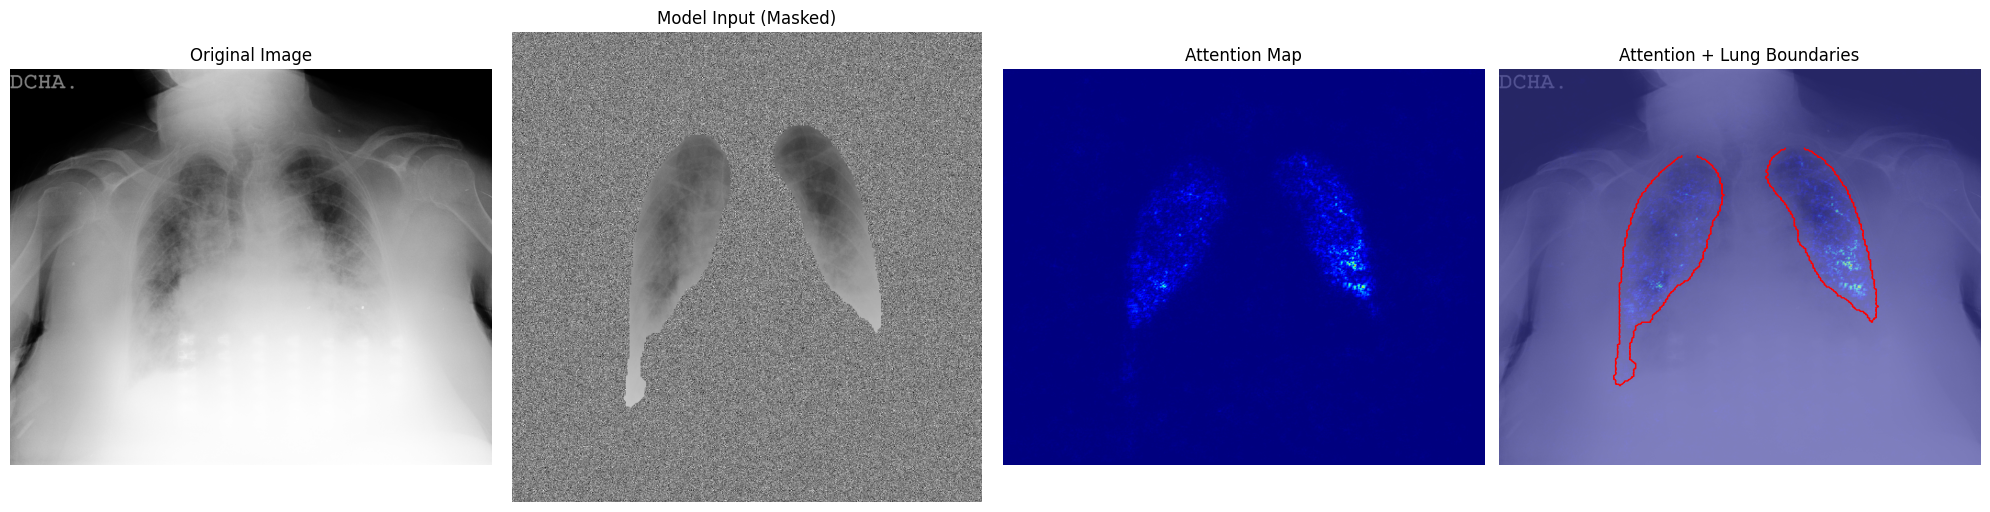

Prediction: COVID-19 (probability: 0.604)



In [43]:
def analyze_sample_simple(model, dataset, idx=0):
    """Analyze a specific sample from your dataset using simple gradient-based attention"""
    # Get sample
    row = dataset.df.iloc[idx]
    img_path = os.path.join(row['Image_Directory'], row['filename'])

    # Load original
    original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Get processed version from dataset
    processed_img, label, source = dataset[idx]
    processed_tensor = processed_img.unsqueeze(0).to(device)

    # Get lung mask for visualization
    img_256 = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
    img_arr = tf.keras.preprocessing.image.img_to_array(img_256).squeeze() / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    mask_pred = dataset.lung_model.predict(img_arr, verbose=0)
    mask = (mask_pred.squeeze() > 0.5).astype(np.uint8)
    lung_mask = cv2.resize(mask, (original.shape[1], original.shape[0]))

    print(f"Analyzing sample {idx}: {row['filename']}")
    print(f"True label: {label.item():.0f}, Source: {source}")

    # Visualize
    attention = simple_gradcam_analysis(model, processed_tensor, original, lung_mask)

    return attention
print("# Simple gradient-based attention (recommended):")
attention = analyze_sample_simple(model, val_dataset, idx=255)
print()



# **Another Kaggle Source**
Contains only negative samples, both normal and viral pneumonia.

In [44]:
import kagglehub
# This is only ~2GB
path_to_independent_data= kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path_to_independent_data)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [45]:
image_dirs=[]
fnames=[]
labels=[]
sources=[]
patient_ids=[]
neg_types=[]
for dir in ['PNEUMONIA', 'NORMAL']:
  path_to_data=os.path.join(path_to_independent_data,'chest_xray','test',dir)
  files=os.listdir(path_to_data )
  for file in files:
    image_dirs.append(path_to_data)
    fnames.append(file)
    labels.append('negative')
    sources.append('unknown')
    patient_id=file.split('_')[0]
    patient_ids.append(patient_id)
    neg_types.append(dir)
new_negative_df=pd.DataFrame({'Image_Directory':image_dirs,'filename':fnames,'label':labels,'source':sources,'patient_id':patient_ids,'negative_type':neg_types})

normal_df=new_negative_df[new_negative_df['negative_type']=='NORMAL']
pneumonia_df=new_negative_df[new_negative_df['negative_type']=='PNEUMONIA']

test_normal_dataset = CovidClassifierDataset(normal_df, transform=val_transform)
test_normal_loader = DataLoader(test_normal_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

test_pneumonia_dataset = CovidClassifierDataset(pneumonia_df, transform=val_transform)
test_pneumonia_loader = DataLoader(test_pneumonia_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)
print('Normal Images')
show_predictions_and_masks(model, segmentation_model_instance, test_normal_loader, device, num_images=8)
print('Non Covid Pneumonia Cases')
show_predictions_and_masks(model, segmentation_model_instance, test_pneumonia_loader, device, num_images=8)

Output hidden; open in https://colab.research.google.com to view.

The model is able to identify these negative samples as non-covid

## **University of Denver COVID Chest X-ray Project Dataset**

- This dataset was originally provided as part of a University of Denver course, with no direct public link or GitHub repository known.
- The dataset consists of **603 chest X-ray images** divided into three categories:
    - **COVID-19**: 221 images
    - **Normal**: 234 images
    - **Viral Pneumonia**: 148 images

- Images were extracted from a provided zip archive and are organized into corresponding folders: `COVID`, `Normal`, `Viral Pneumonia`.
- The chest X-rays include only frontal (PA or AP) views; lateral (side-view) images have been removed for consistency.
- The dataset also contains `Outliers` directories produced by automated outlier detection (including methods such as Isolation Forest and DBSCAN), which were not used in primary modeling.
- Total unique patients: 254

- **Label distribution:**
    - Positive (COVID): 221
    - Negative (Normal + Viral Pneumonia): 382

- **Note on Data Source:**  
  The direct public link or definitive online repository for this collection is not available. Similar datasets can be found on sources like Mendeley Data or GitHub (for example: [COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database), [Mendeley curated COVID-19 PA CXR](https://data.mendeley.com/datasets/9xkhgts2s6/3)), but this project uses the dataset as locally provided in coursework.

---



In [46]:
import os
import zipfile
import pandas as pd

def extract_and_create_dataframe(zip_path, extract_to='covid_project_extracted'):
    """
    Extract Covid_Project.zip and create a structured dataframe

    Args:
        zip_path: Path to Covid_Project.zip
        extract_to: Directory to extract files to

    Returns:
        DataFrame with image information
    """

    # Extract the zip file
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Files extracted to: {extract_to}")

    # The actual data is in Covid_Project subfolder
    base_path = os.path.join(extract_to, 'Covid_Project')

    # Lists to hold data
    image_dirs = []
    fnames = []
    labels = []
    sources = []
    patient_ids = []
    categories = []

    # Expected subdirectories and their corresponding labels
    category_mappings = {
        'COVID': 'positive',
        'Normal ': 'negative',  # Note the space in the folder name
        'Viral Pneumonia': 'negative'
    }
    outlier_files=os.listdir(os.path.join(base_path,'Outliers'))
    print(outlier_files)
    # Process each subdirectory
    for category in ['COVID', 'Normal ', 'Viral Pneumonia']:  # Note space in Normal
        category_path = os.path.join(base_path, category)

        if os.path.exists(category_path):
            print(f"Processing {category.strip()} directory: {category_path}")
            files = [f for f in os.listdir(category_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm'))
                    and not f.startswith('.')]  # Exclude Mac hidden files

            print(f"Found {len(files)} images in {category.strip()}")

            for file in files:
                if file not in outlier_files:
                  image_dirs.append(category_path)
                  fnames.append(file)
                  labels.append(category_mappings[category])
                  sources.append('covid_project')  # Source identifier

                  # Extract patient ID from filename (try different patterns)
                  patient_id = extract_patient_id(file)
                  patient_ids.append(patient_id)

                  categories.append(category.strip())
        else:
            print(f"Warning: Directory {category} not found at {category_path}")

    # Create DataFrame
    df = pd.DataFrame({
        'Image_Directory': image_dirs,
        'filename': fnames,
        'label': labels,
        'source': sources,
        'patient_id': patient_ids,
        'category': categories
    })

    print(f"\nDataFrame created with {len(df)} images")
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print("\nCategory distribution:")
    print(df['category'].value_counts())

    return df

def extract_patient_id(filename):
    """
    Extract patient ID from filename using common patterns
    """
    # Remove file extension
    name = os.path.splitext(filename)[0]

    # Try different common patterns
    if '_' in name:
        # Pattern: COVID_001.jpg or similar
        return name.split('_')[0] + '_' + name.split('_')[1] if len(name.split('_')) > 1 else name.split('_')[0]
    elif '-' in name:
        # Pattern: COVID-001.jpg
        return name.split('-')[0] + '-' + name.split('-')[1] if len(name.split('-')) > 1 else name.split('-')[0]
    else:
        # Use first part of filename or whole name
        return name[:10] if len(name) > 10 else name

def explore_extracted_structure(extract_path='covid_project_extracted'):
    """
    Explore the structure of the extracted files
    """
    print("Exploring extracted file structure:")
    for root, dirs, files in os.walk(extract_path):
        level = root.replace(extract_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files)-5} more files')

# Usage - corrected to use project_dir variable
zip_path = os.path.join(project_dir, 'Covid_Project.zip')

# First explore the structure
print("=" * 50)
print("EXPLORING FILE STRUCTURE")
print("=" * 50)

# Extract and explore
df = extract_and_create_dataframe(zip_path)

# Explore structure
explore_extracted_structure()

print("\n" + "=" * 50)
print("DATAFRAME SUMMARY")
print("=" * 50)

print(f"Total images: {len(df)}")
print(f"Unique patients: {df['patient_id'].nunique()}")

# Show sample rows
print("\nSample rows:")
print(df.head())

print("\nDataFrame info:")
print(df.info())

# Create separate datasets for testing
covid_df = df[df['category'] == 'COVID']
normal_df = df[df['category'] == 'Normal']
viral_pneumonia_df = df[df['category'] == 'Viral Pneumonia']

print(f"\nSeparate datasets created:")
print(f"COVID cases: {len(covid_df)}")
print(f"Normal cases: {len(normal_df)}")
print(f"Viral Pneumonia cases: {len(viral_pneumonia_df)}")

# Save the dataframe
df.to_csv('covid_project_dataset.csv', index=False)
print(f"\nDataFrame saved to: covid_project_dataset.csv")

EXPLORING FILE STRUCTURE
Extracting zip file...
Files extracted to: covid_project_extracted
['Isolation_Forest', '.DS_Store', 'DBSCAN_OUTLIERS']
Processing COVID directory: covid_project_extracted/Covid_Project/COVID
Found 221 images in COVID
Processing Normal directory: covid_project_extracted/Covid_Project/Normal 
Found 234 images in Normal
Processing Viral Pneumonia directory: covid_project_extracted/Covid_Project/Viral Pneumonia
Found 148 images in Viral Pneumonia

DataFrame created with 603 images

Label distribution:
label
negative    382
positive    221
Name: count, dtype: int64

Category distribution:
category
Normal             234
COVID              221
Viral Pneumonia    148
Name: count, dtype: int64
Exploring extracted file structure:
covid_project_extracted/
  __MACOSX/
    ._Covid_Project
    Covid_Project/
      ._Normal 
      ._Outliers
      ._COVID
      ._Viral Pneumonia
      ._.DS_Store
      Viral Pneumonia/
        ._Viral Pneumonia-person1629_virus_2823.jpeg
  

In [47]:
# Create separate datasets for each category
covid_df = df[df['category'] == 'COVID']
normal_df = df[df['category'] == 'Normal']
viral_pneumonia_df = df[df['category'] == 'Viral Pneumonia']

# Create datasets and loaders for each category
covid_test_dataset = CovidClassifierDataset(covid_df.sample(frac=1), transform=val_transform)
covid_test_loader = DataLoader(covid_test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

normal_test_dataset = CovidClassifierDataset(normal_df.sample(frac=1), transform=val_transform)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

viral_test_dataset = CovidClassifierDataset(viral_pneumonia_df.sample(frac=1), transform=val_transform)
viral_test_loader = DataLoader(viral_test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

# Test each category
print("="*60)
print("COVID CASES (Should predict POSITIVE)")
print("="*60)
show_predictions_and_masks(model, segmentation_model_instance, covid_test_loader, device, num_images=8)

print("\n" + "="*60)
print("NORMAL CASES (Should predict NEGATIVE)")
print("="*60)
show_predictions_and_masks(model, segmentation_model_instance, normal_test_loader, device, num_images=8)

print("\n" + "="*60)
print("VIRAL PNEUMONIA CASES (Should predict NEGATIVE)")
print("="*60)
show_predictions_and_masks(model, segmentation_model_instance, viral_test_loader, device, num_images=8)

# Get overall performance metrics for this external dataset
print("\n" + "="*60)
print("OVERALL PERFORMANCE ON EXTERNAL DATASET")
print("="*60)

all_test_dataset = CovidClassifierDataset(df, transform=val_transform)
all_test_loader = DataLoader(all_test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_with_source)

# Calculate accuracy for each category
def evaluate_by_category(model, loader, device):
    model.eval()
    predictions = []
    true_labels = []
    sources = []

    with torch.no_grad():
        for images, labels, batch_sources in loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            sources.extend(batch_sources)

    return predictions, true_labels, sources

preds, true_labels, sources = evaluate_by_category(model, all_test_loader, device)

# Calculate metrics by category
for category in ['COVID', 'Normal', 'Viral Pneumonia']:
    category_df = df[df['category'] == category]
    category_indices = category_df.index.tolist()

    if len(category_indices) > 0:
        category_preds = [preds[i] for i in range(len(preds)) if i < len(category_df)]
        category_true = [true_labels[i] for i in range(len(true_labels)) if i < len(category_df)]

        if len(category_preds) > 0:
            accuracy = sum(p == t for p, t in zip(category_preds, category_true)) / len(category_preds)
            expected_label = "Positive" if category == "COVID" else "Negative"
            print(f"{category} Accuracy: ", accuracy)

Output hidden; open in https://colab.research.google.com to view.